## 1. 라이브러리 불러오기
딥러닝 CNN 학습을 위한 torch, plt, torchvision을 불러옵니다.

In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

## 2. 훈련용 데이터셋 시각화
딥러닝 CNN 학습을 위한 훈련용 데이터셋을 시각화 처리한다.

In [4]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data =datasets.MNIST(
     root = 'data',
    train = False,
    transform = ToTensor()
)

In [12]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


60000개의 데이터로 학습을 해서 10000개의 데이터로 얼마나 학습이 잘 되었는지 테스트를 진행할 것이다.

In [15]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


총 60000개의 이미지(샘플 수), 각 이미지의 크기가 28x28 픽셀

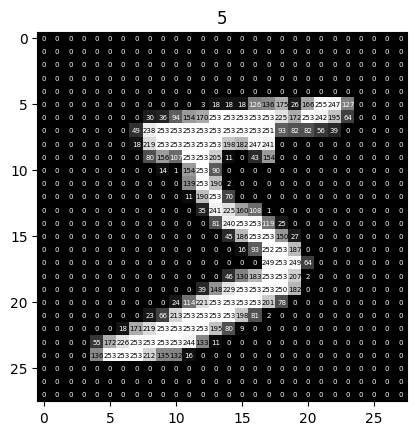

In [29]:
fig, ax = plt.subplots()
ax.imshow(train_data.data[0], cmap= 'gray')

for i in range(train_data.data[0].shape[0]):
    for j in range(train_data.data[0].shape[1]):
        c = 1 if train_data.data[0][i, j].item() < 128 else 0
        ax.text(j, i, str(train_data.data[0][i, j].item()), color=(c, c, c), ha='center', va='center', fontsize=5)

plt.title('%i' % train_data.targets[0])
plt.show()

레이블(정답)은 5이며 어두운 곳은 0에 가까운 수로 표시되고 밝은 곳은 255에 가까운 수로 표현되고 있다.


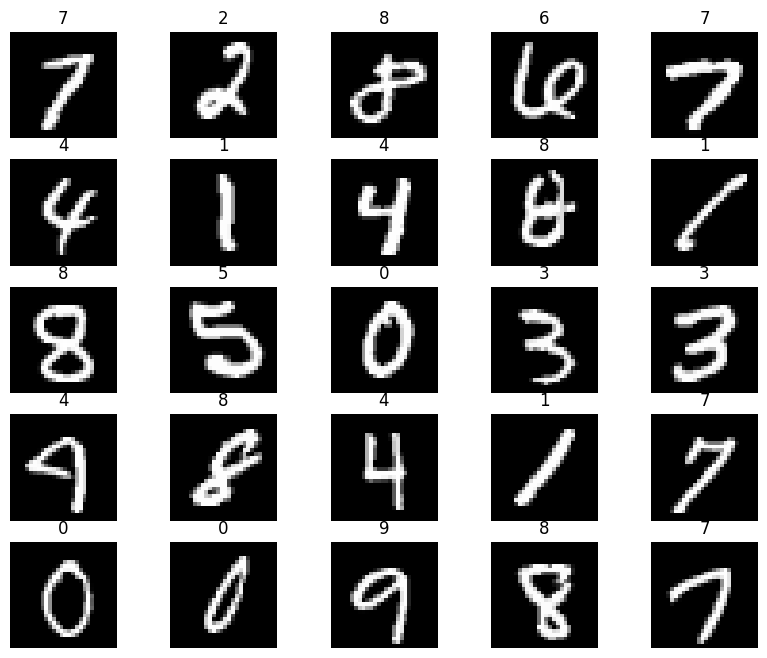

In [72]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

위 숫자들은 랜덤한 샘플들의 손글씨이며 모양새가 조금씩 다르지만 레이블(정답)이 존재한다. `지도학습`

## 3. 미니배치
- 배치 사이즈 100장이므로 100장 한꺼번에 처리 **연산 속도 향상**,   
- shuffle=True이므로 매 epoch마다 데이터 순서를 **섞어**주므로 과적합 방지 → **학습 일반화 향상**

In [45]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                           batch_size=100,
                                           shuffle=True,
                                           num_workers=1),
    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1dea1e13e80>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1dea1e111e0>}

## 4. 합성곱 신경망(CNN) 클래스 선언

이 모델은 **2개의 Convolutional Layer**와 **1개의 Fully-connected Layer**로 구성되어 있다.

---

- `__init__` 파트는 어떠한 레이어들을 모듈로 쓸지 선언  
     layer1, 2는 **Conv → ReLU → MaxPool** 과정을 지나며 마지막에 **Fully-connected layer**를 거친다.      
* `forward` __init__에서 정의를 내린 레이어들을 **forward**에서 사용

In [46]:
# CNN Model (2 conv Layers) 클래스 선언
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(                                 # 사이즈 변화
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),    # 28 x 28 ==> 32 x 32x ==> 28 x 28
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))                   # 28 x 28 ==> 14 x 14
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),   # 14 x 14 ==> 18 x 18 ==> 14 x 14
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))                   # 14 x 14 ==> 7 x 7
        self.fc = torch.nn.Linear(32 * 7 * 7, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [47]:
# model에 CNN 적용
model = CNN()
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [64]:
# 여러 변수 적용
learning_rate = 0.01
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
training_epochs = 10

## 5. 모델 훈련 단계

In [65]:
# train my model
total_batch = len(loaders['train'])
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in loaders['train']:
        optimizer.zero_grad()           # gradient clear before computing new gradient for the new batch
        pred = model(X)
        cost = loss_func(pred, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

[Epoch:    1] cost = 0.140135914
[Epoch:    2] cost = 0.0552573204
[Epoch:    3] cost = 0.0462290533
[Epoch:    4] cost = 0.0434174016
[Epoch:    5] cost = 0.0413126722
[Epoch:    6] cost = 0.0387721062
[Epoch:    7] cost = 0.0384461693
[Epoch:    8] cost = 0.035648711
[Epoch:    9] cost = 0.0370304734
[Epoch:   10] cost = 0.0342870839
Learning Finished!


간혹 cost가 늘긴 하지만 대부분의 cost가 줄어들고 있기 때문에 잘 훈련되고 있는걸 확인할 수 있다.

## 6. 테스트용 데이터셋 시각화
훈련이 잘 되었는지 검증을 위한 테스트용 데이터셋을 시각화한다.

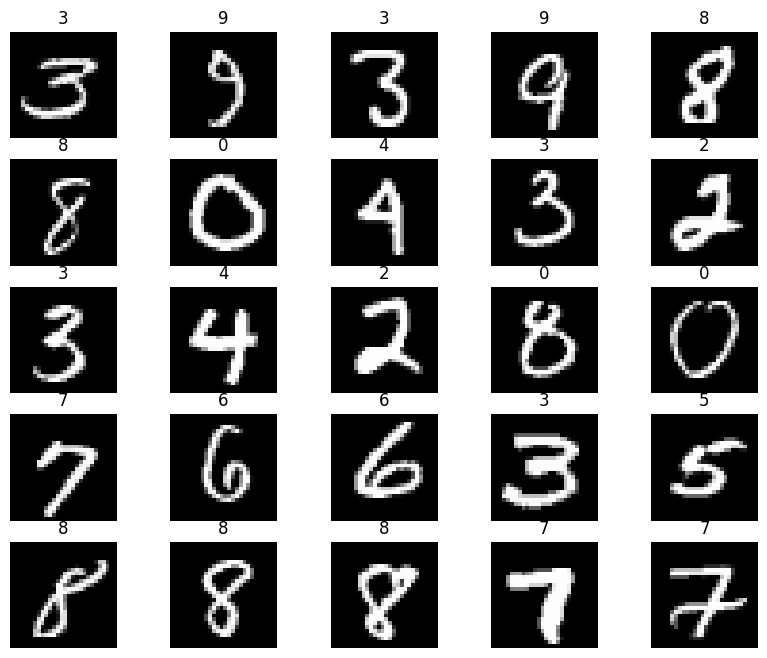

In [69]:
model.eval()
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    test_output = model(torch.unsqueeze(loaders['test'].dataset[sample_idx][0], dim=0))
    label = torch.argmax(test_output)
    figure.add_subplot(rows, cols, i)
    plt.title(label.numpy())
    plt.axis("off")
    plt.imshow(loaders['test'].dataset[sample_idx][0].squeeze().detach().numpy(), cmap="gray")
plt.show()

위 레이블은 예측한 값이고 대부분 맞췄지만 간혹 실수해서 틀린 값이 존재한다.